# Sentiment Analysis with minLSTM and minGRU

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from datasets import load_dataset

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')


Using device: cuda


## Visualising the data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

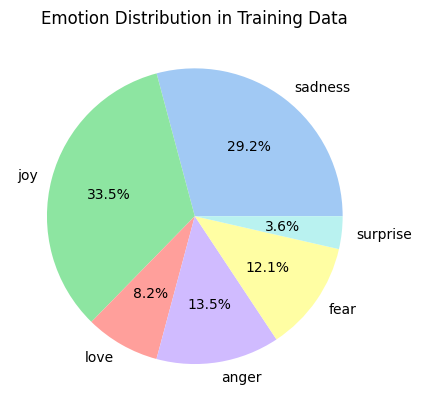

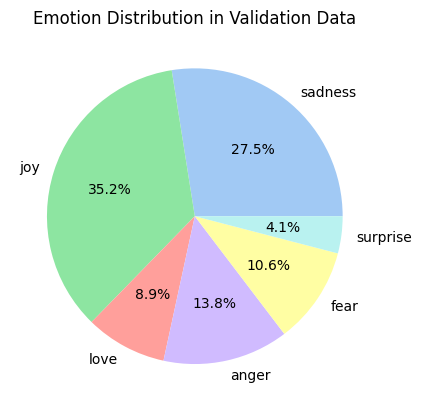

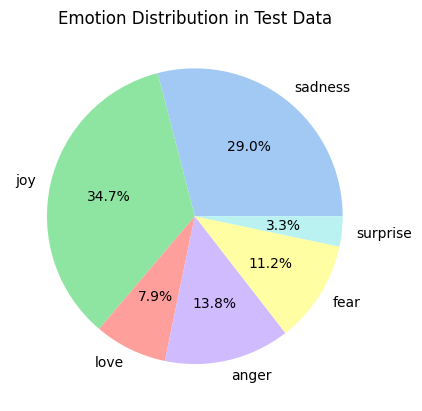

Random guessing accuracy: 16.67%


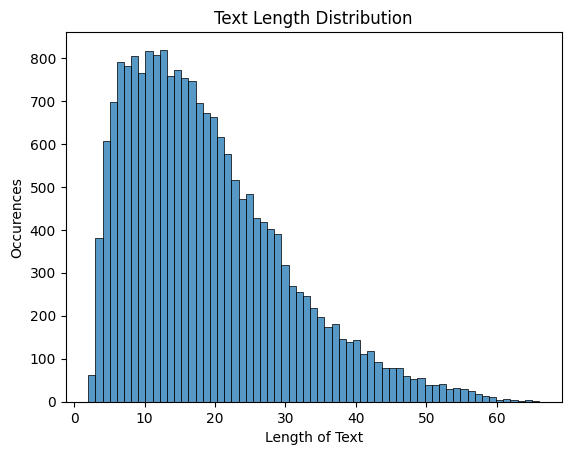

Range: 2 - 66
Mean: 19.14
Standard Deviation: 10.97


In [3]:
ds = load_dataset("dair-ai/emotion", "split")

train_labels = ds['train']['label']
validation_labels = ds['validation']['label']
test_labels = ds['test']['label']

emotions ={0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

labels, counts = np.unique(train_labels, return_counts=True)
plt.title('Emotion Distribution in Training Data')
plt.pie(counts, labels=emotions.values(), autopct='%1.1f%%', colors=sns.color_palette('pastel6'))
plt.show()
plt.clf()


labels, counts = np.unique(validation_labels, return_counts=True)
plt.title('Emotion Distribution in Validation Data')
plt.pie(counts, labels=emotions.values(), autopct='%1.1f%%',colors=sns.color_palette('pastel6'))
plt.show()
plt.clf()

labels, counts = np.unique(test_labels, return_counts=True)
plt.title('Emotion Distribution in Test Data')
plt.pie(counts, labels=emotions.values(), autopct='%1.1f%%', colors=sns.color_palette('pastel6'))
plt.show()

#monte carlo simulation
correct = 0
total = 0
for i in range(10000):
    pred = np.random.randint(0, 6, len(test_labels))
    correct += np.sum(pred == test_labels)
    total += len(test_labels)

print(f'\nRandom guessing accuracy: {correct/total*100:.2f}%\n')

all_texts = ds['train']['text']
all_texts.extend(ds['validation']['text'])
all_texts.extend(ds['test']['text'])

text_lengths = [len(text.split()) for text in all_texts]
sns.histplot(text_lengths)
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Occurences')
plt.show()



print(f'Range: {np.min(text_lengths)} - {np.max(text_lengths)}')
print(f'Mean: {np.mean(text_lengths):.2f}')
print(f'Standard Deviation: {np.std(text_lengths):.2f}')




## Loading the dataset

In [4]:
def create_tokenizer(text, vocab_size):
    tokenizer = Tokenizer(WordLevel(unk_token="<OOV>"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(vocab_size=vocab_size, special_tokens=["<OOV>", "<PAD>"], min_frequency=1)
    tokenizer.train_from_iterator(text, trainer)

    return tokenizer



In [5]:

def collate_fn(batch):
    """
    A self-defined collate function for padding the sequences before feeding them into the model
    """
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, torch.tensor(labels, dtype=torch.long)

class EmotionDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        sentence = self.tokenizer.encode(sentence).ids
        return torch.tensor(sentence, dtype=torch.long), torch.tensor(label, dtype=torch.long)

ds = load_dataset("dair-ai/emotion", "split")

tokenizer = create_tokenizer(ds['train']['text'], len(ds['train']['text']))


train = EmotionDataset(ds['train']['text'], ds['train']['label'], tokenizer)
test = EmotionDataset(ds['test']['text'], ds['test']['label'], tokenizer)
val = EmotionDataset(ds['validation']['text'], ds['validation']['label'], tokenizer)



testLoader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True, collate_fn=collate_fn)
trainLoader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, collate_fn=collate_fn)
valLoader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, collate_fn=collate_fn)


## Training

In [34]:
import time


class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0, path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.model_states = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.path is not None:
            torch.save(model.state_dict(), self.path)
        else:
            self.model_states = model.state_dict()

def validation(model, valLoader, criterion):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for data in valLoader:
            sequences, labels = data
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return loss / len(valLoader), correct / total


def training(model, trainLoader, valLoader, criterion, optimizer, num_epochs, early_stopping = None):
    model.to(device)

    train_losses = []
    val_losses = []

    t1 = time.time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for i, (sentence, label) in enumerate(trainLoader):
            sentence, label = sentence.to(device), label.to(device)

            optimizer.zero_grad()

            output = model(sentence)
            #print('output',output.shape)
            #print('label',label.shape)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()



        if epoch % 2 == 0:
            val_loss, val_acc = validation(model, valLoader, criterion)
            train_losses.append(train_loss / len(trainLoader))
            val_losses.append(val_loss)
            if early_stopping is not None:
                early_stopping(val_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
            print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(trainLoader)}, Val Loss: {val_loss}, Val Acc: {val_acc}")
    t2 = time.time()
    print(f"\nTraining time: {(int)((t2 - t1)//60)}m {((t2 - t1) % 60):.2f}s")
    return train_losses, val_losses

### MinLSTM

In [ ]:
from minRNN import minRNN

num_classes = 6
vocab_size = len(tokenizer.get_vocab())
embedding_size = 256
hidden_dim = 512
cell_type = 'lstm'
dropout = 0.2
num_layers = 2

model_1 = minRNN(hidden_dim, embedding_size, vocab_size, num_classes, cell_type=cell_type, dropout=dropout, num_layers=num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_1.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, min_delta=0.001)
num_epochs = 50

train_losses, val_losses = training(model_1, trainLoader, valLoader, criterion, optimizer, num_epochs, early_stopping)

Epoch 1, Train Loss: 1.6023180339336396, Val Loss: 1.5869324888501848, Val Acc: 0.352
Epoch 3, Train Loss: 1.5085436408519746, Val Loss: 1.2376518665798126, Val Acc: 0.359
Epoch 5, Train Loss: 1.0111394735574721, Val Loss: 0.9340307163813758, Val Acc: 0.5075
Epoch 7, Train Loss: 0.7403246864080429, Val Loss: 0.6910118479577322, Val Acc: 0.7
Epoch 9, Train Loss: 0.3603820621967316, Val Loss: 0.37331405222888975, Val Acc: 0.8855
Epoch 11, Train Loss: 0.2439566342867911, Val Loss: 0.3137511930295399, Val Acc: 0.8975
Epoch 13, Train Loss: 0.19750882205739617, Val Loss: 0.2833849857635205, Val Acc: 0.9145
Epoch 15, Train Loss: 0.15257010394893586, Val Loss: 0.31425023631798843, Val Acc: 0.907
Epoch 17, Train Loss: 0.14434345575794577, Val Loss: 0.3895445361969963, Val Acc: 0.9105
Epoch 19, Train Loss: 0.11895221206953284, Val Loss: 0.36248666346664465, Val Acc: 0.908
Epoch 21, Train Loss: 0.09918947471445426, Val Loss: 0.3618829465352945, Val Acc: 0.916
Early stopping

Training time: 3m 34.

Text(0.5, 1.0, 'Training and Validation Loss for MinLSTM')

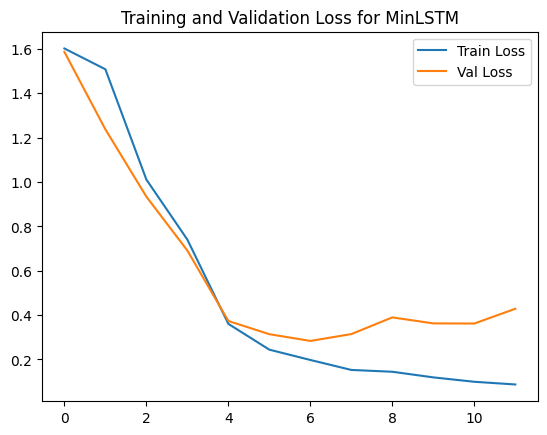

In [37]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training and Validation Loss for MinLSTM")

### Bag Of Words

In [ ]:
from bow import BagOfWords

num_classes = 6
vocab_size = len(tokenizer.get_vocab())
embedding_size = 256
hidden_dim = 512


model_2 = BagOfWords(vocab_size, embedding_size, hidden_dim, num_classes, dropout=0.25)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_2.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, min_delta=0.001)
num_epochs = 50

train_losses, val_losses = training(model_2, trainLoader, valLoader, criterion, optimizer, num_epochs, early_stopping)

Epoch 1, Train Loss: 1.585352741241455, Val Loss: 1.5727270860520621, Val Acc: 0.3755
Epoch 3, Train Loss: 1.0906977062225343, Val Loss: 0.9441792132362486, Val Acc: 0.661
Epoch 5, Train Loss: 0.41289787988364696, Val Loss: 0.5619291192482389, Val Acc: 0.825
Epoch 7, Train Loss: 0.2086281483117491, Val Loss: 0.4965182399702451, Val Acc: 0.849
Epoch 9, Train Loss: 0.1356766573600471, Val Loss: 0.5369637594336555, Val Acc: 0.8555
Epoch 11, Train Loss: 0.10295498233567923, Val Loss: 0.5336107623482508, Val Acc: 0.8685
Epoch 13, Train Loss: 0.0825958628221415, Val Loss: 0.5604198466217707, Val Acc: 0.8665
Epoch 15, Train Loss: 0.07667244116868824, Val Loss: 0.5753098450719364, Val Acc: 0.8665
Early stopping

Training time: 0m 40.71s


Text(0.5, 1.0, 'Training and Validation Loss for BoW')

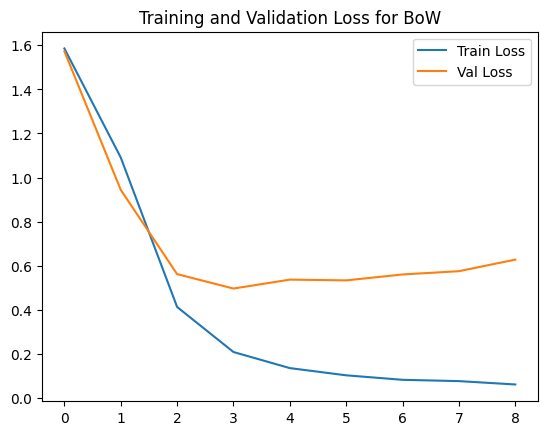

In [40]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training and Validation Loss for BoW")

## Evaluation

In [41]:
def evaluate(model, testLoader):
    model.eval()
    model_name = model.__class__.__name__
    all_labels = []
    all_preds = []

    with torch.no_grad():
        correct = 0
        total = 0
        for data in testLoader:
            sequences, labels = data
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of {model_name} on the test data: {100 * correct / total}%')
    disp = ConfusionMatrixDisplay(confusion_matrix(all_labels, all_preds, normalize='true'), display_labels=emotions.values())
    disp.plot()
    plt.show()



 Evaluating minRNN model
Accuracy of minRNN on the test data: 91.2%


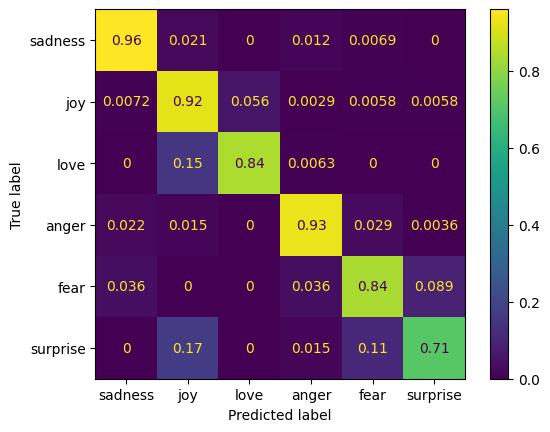


 Evaluating Bag of Words model
Accuracy of BagOfWords on the test data: 85.5%


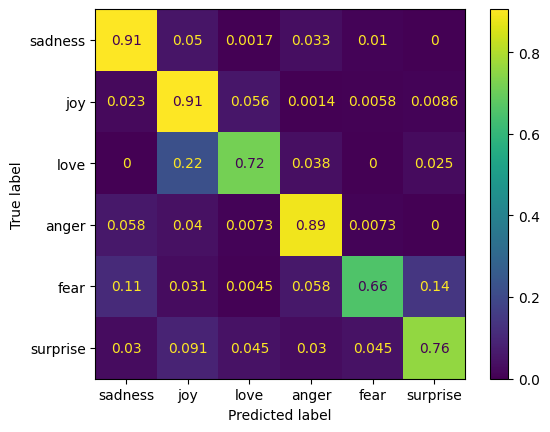

In [42]:
print('\n Evaluating minRNN model')
evaluate(model_1, testLoader)

print('\n Evaluating Bag of Words model')
evaluate(model_2, testLoader)

In [43]:

def analyze_predictions(model, testLoader, tokenizer, num_samples=10, device='cpu'):
    '''
    Outputs a sample of correct and incorrect predictions from the model
    '''
    correct_predictions = []
    correct_labels = []
    incorrect_predictions = []
    incorrect_labels = []
    incorrect_true_labels = []

    model.eval()
    with torch.no_grad():
        test_iter = iter(testLoader)
        try:
            while len(correct_predictions) < num_samples or len(incorrect_predictions) < num_samples:
                # Get batch
                text, label = next(test_iter)
                text, label = text.to(device), label.to(device)

                # Get predictions
                output = model(text)
                _, predicted = torch.max(output.data, 1)
                correct_mask = predicted == label

                # Collect samples
                for i in range(len(label)):
                    if correct_mask[i] and len(correct_predictions) < num_samples:
                        correct_predictions.append(tokenizer.decode(text[i].cpu().numpy()))
                        correct_labels.append(label[i].item())
                    elif not correct_mask[i] and len(incorrect_predictions) < num_samples:
                        incorrect_predictions.append(tokenizer.decode(text[i].cpu().numpy()))
                        incorrect_labels.append(predicted[i].item())
                        incorrect_true_labels.append(label[i].item())

        except StopIteration:
            print("Reached end of dataset")

    # Print results
    print("\nCorrect Predictions:")
    for text, label in zip(correct_predictions, correct_labels):
        print(f"Label: {emotions[label]}, Text: {text}\n")

    print("\nIncorrect Predictions:")
    for text, true, pred in zip(incorrect_predictions,incorrect_true_labels, incorrect_labels):
        print(f"Predicted: {emotions[pred]}, True: {emotions[true]}, Text: {text}\n")

    return correct_predictions, correct_labels, incorrect_predictions, incorrect_labels



In [44]:
print('\n Analyzing minRNN model')
results = analyze_predictions(model_1, testLoader, tokenizer, num_samples=10, device=device)


print('\n Analyzing Bag of Words model')
results = analyze_predictions(model_2, testLoader, tokenizer, num_samples=10, device=device)


 Analyzing minRNN model

Correct Predictions:
Label: joy, Text: i find it me and i feel productive making food as the end product should taste nice and will myself and other people

Label: joy, Text: i feel like that s acceptable

Label: joy, Text: i felt this emotion when my name was announced on the radio that i had been selected to come to school for health sciences to take a training course as a medical

Label: anger, Text: i feel appalled that i took advantage of my old friend s kindness

Label: sadness, Text: i stop feeling guilty

Label: sadness, Text: i feel so embarrassed

Label: sadness, Text: i had that kinda feeling but ignored it

Label: sadness, Text: i am feeling depressed cursing my luck

Label: sadness, Text: im much more peaceful and happy when the house is clean the food is good and my kids arent feeling needy

Label: joy, Text: i feel bouncy and i could easily run out there few hours


Incorrect Predictions:
Predicted: love, True: joy, Text: i just tell people i fe